<a href="https://colab.research.google.com/github/AzadehHa/Data-Analytics/blob/main/RecruiterModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cluster 0 Characteristics:
        Public Repos     Followers  Total Stars  Total_Commits    Total_PRs  \
count    961.000000    961.000000    961.00000     961.000000   961.000000   
mean      42.178980    120.379813    356.91155    2240.584807    86.698231   
std       49.250119    939.151470   1971.73355   13750.598938   365.038823   
min        0.000000     11.000000      0.00000       0.000000     0.000000   
25%       15.000000     17.000000      8.00000      65.000000     0.000000   
50%       28.000000     29.000000     30.00000     295.000000     8.000000   
75%       50.000000     62.000000    115.00000    1013.000000    40.000000   
max      595.000000  27420.000000  45326.00000  342695.000000  7455.000000   

       Total Issues  Starred Repositories  Forked Repositories  
count    961.000000            961.000000           961.000000  
mean      69.526535            204.977107            19.961498  
std      303.176193            593.136793            38.224005  
min      

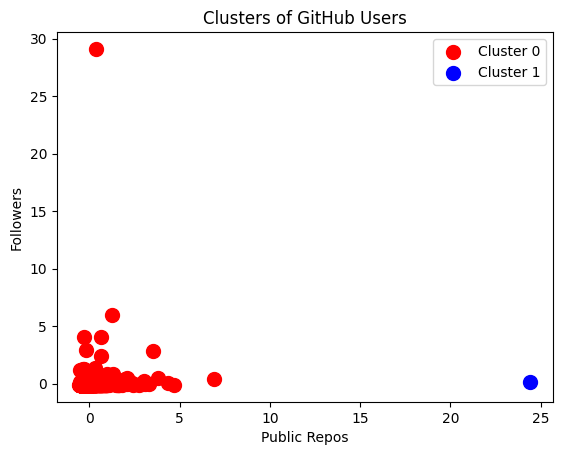

In [5]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("Cleaned_GitHub_Data-2.csv")

# Select features
features = ['Public Repos', 'Followers', 'Total Stars', 'Total_Commits', 'Total_PRs', 'Total Issues', 'Starred Repositories', 'Forked Repositories']
X = df[features]

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means with k=2
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Analyze cluster characteristics
print("Cluster 0 Characteristics:\n", df[df['Cluster'] == 0][features].describe())
print("\nCluster 1 Characteristics:\n", df[df['Cluster'] == 1][features].describe())

# Visualize the clusters (example with two features)
plt.scatter(X_scaled[df['Cluster'] == 0, 0], X_scaled[df['Cluster'] == 0, 1], s=100, c='red', label='Cluster 0')
plt.scatter(X_scaled[df['Cluster'] == 1, 0], X_scaled[df['Cluster'] == 1, 1], s=100, c='blue', label='Cluster 1')
plt.title('Clusters of GitHub Users')
plt.xlabel(features[0]) #X_scaled[:, 0]
plt.ylabel(features[1]) #X_scaled[:, 1]
plt.legend()
plt.show()

# Add cluster labels to the DataFrame and save (optional)
df.to_csv("github_clusters.csv", index=False)


Cluster 0 Characteristics:
        Public Repos    Followers  Total Stars  Total_Commits   Total_PRs  \
count    687.000000   687.000000   687.000000     687.000000  687.000000   
mean      28.711790    41.189229    47.097525     367.419214   14.764192   
std       20.873454    89.372019    70.094256     489.333666   26.736916   
min        1.000000    11.000000     0.000000       0.000000    0.000000   
25%       13.000000    15.000000     5.000000      42.000000    0.000000   
50%       23.000000    23.000000    20.000000     210.000000    4.000000   
75%       40.000000    39.000000    58.000000     479.500000   17.000000   
max      119.000000  1329.000000   613.000000    3893.000000  302.000000   

       Total Issues  Starred Repositories  Forked Repositories  \
count    687.000000            687.000000           687.000000   
mean      12.251820            115.796215            10.462882   
std       26.976651            326.548108            12.397028   
min        0.000000    

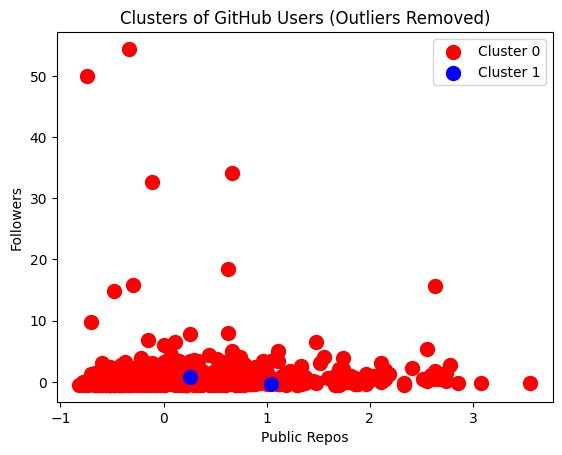


Clustered data saved to github_clusters_cleaned.csv


In [11]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("Cleaned_GitHub_Data-2.csv")

# --- Feature Engineering ---
df['Stars per Follower'] = df['Total Stars'] / (df['Followers'] + 1)
df['Commits per Repo'] = df['Total_Commits'] / (df['Public Repos'] + 1)
df['PRs per Commit'] = df['Total_PRs'] / (df['Total_Commits'] + 1)

# --- Feature Selection ---
features = ['Public Repos', 'Followers', 'Total Stars', 'Total_Commits', 'Total_PRs', 'Total Issues', 'Starred Repositories', 'Forked Repositories', 'Stars per Follower', 'Commits per Repo', 'PRs per Commit']
X = df[features].fillna(0)  # Handle potential NaN values from division

# --- Outlier Detection using IQR ---
def find_outliers_iqr(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    return outliers

# --- Identify Outliers for Each Feature ---
outliers = {}
for feature in features:
    outliers[feature] = find_outliers_iqr(df, feature)

# --- Combined Outlier Analysis ---
# Identify users who are outliers in at least 2 features
multiple_outliers = df[df.apply(lambda row: sum([row['Username'] in outliers[feature]['Username'].tolist() for feature in features]) >= 2, axis=1)]
usernames_to_remove = multiple_outliers['Username'].tolist()

# --- Remove Outliers ---
df_no_outliers = df[~df['Username'].isin(usernames_to_remove)].copy() # Added copy() to avoid SettingWithCopyWarning

# --- Scaling (AFTER Outlier Removal!) ---
X_no_outliers = df_no_outliers[features].fillna(0)  # Get feature data for the cleaned DataFrame
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_no_outliers)

# --- K-Means Clustering (AFTER Outlier Removal!) ---
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=500, n_init=20, random_state=0)
df_no_outliers['Cluster'] = kmeans.fit_predict(X_scaled)  # Assign clusters to the cleaned DataFrame

# --- Analyze cluster characteristics
print("Cluster 0 Characteristics:\n", df_no_outliers[df_no_outliers['Cluster'] == 0][features].describe())
print("\nCluster 1 Characteristics:\n", df_no_outliers[df_no_outliers['Cluster'] == 1][features].describe())

# --- Visualization ---
plt.scatter(X_scaled[df_no_outliers['Cluster'] == 0, 0], X_scaled[df_no_outliers['Cluster'] == 0, 1], s=100, c='red', label='Cluster 0')
plt.scatter(X_scaled[df_no_outliers['Cluster'] == 1, 0], X_scaled[df_no_outliers['Cluster'] == 1, 1], s=100, c='blue', label='Cluster 1')
plt.title('Clusters of GitHub Users (Outliers Removed)')
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.legend()
plt.show()

# --- Save Results to CSV ---
df_no_outliers.to_csv("github_clusters_cleaned.csv", index=False)
print("\nClustered data saved to github_clusters_cleaned.csv")


Cluster 0 Characteristics:
        Public Repos  Followers_log  Total Stars_log  Total Commits_log  \
count           1.0       1.000000         1.000000           1.000000   
mean         1997.0       5.509388         7.619233           2.197225   
std             NaN            NaN              NaN                NaN   
min          1997.0       5.509388         7.619233           2.197225   
25%          1997.0       5.509388         7.619233           2.197225   
50%          1997.0       5.509388         7.619233           2.197225   
75%          1997.0       5.509388         7.619233           2.197225   
max          1997.0       5.509388         7.619233           2.197225   

       Total_PRs  Total Issues  Starred Repositories  Forked Repositories  \
count        1.0           1.0                   1.0                  1.0   
mean     25527.0          22.0                4903.0               1978.0   
std          NaN           NaN                   NaN                  NaN 

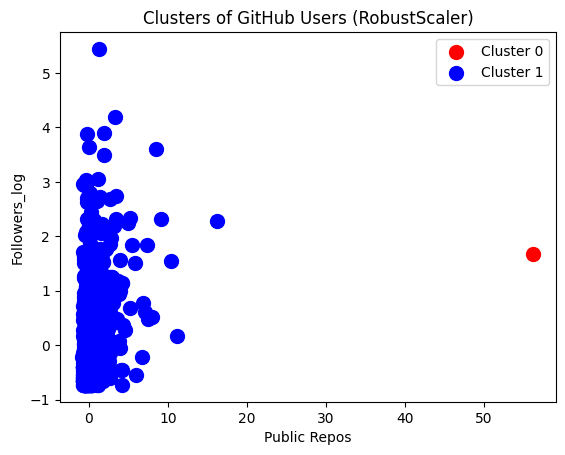


Clustered data saved to github_clusters_robust.csv


In [24]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler, StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Load the data
df = pd.read_csv("Cleaned_GitHub_Data-2.csv")

# --- Feature Engineering and Transformation ---
# Apply log transformation to skewed features
df['Followers_log'] = np.log1p(df['Followers'])
df['Total Stars_log'] = np.log1p(df['Total Stars'])
df['Total Commits_log'] = np.log1p(df['Total_Commits'])

df['Stars per Follower'] = df['Total Stars'] / (df['Followers'] + 1)
df['Commits per Repo'] = df['Total_Commits'] / (df['Public Repos'] + 1)
df['PRs per Commit'] = df['Total_PRs'] / (df['Total_Commits'] + 1)

# --- Feature Selection ---
features = ['Public Repos', 'Followers_log', 'Total Stars_log', 'Total Commits_log', 'Total_PRs', 'Total Issues', 'Starred Repositories', 'Forked Repositories', 'Stars per Follower', 'Commits per Repo', 'PRs per Commit']
X = df[features].fillna(0)

# --- Scaling using RobustScaler ---
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# --- K-Means Clustering ---
kmeans = KMeans(n_clusters=2, init='random', max_iter=500, n_init=20, random_state=0)  # Keep init='random'
df['Cluster'] = kmeans.fit_predict(X_scaled)

# --- Analyze cluster characteristics
print("Cluster 0 Characteristics:\n", df[df['Cluster'] == 0][features].describe())
print("\nCluster 1 Characteristics:\n", df[df['Cluster'] == 1][features].describe())

# --- Visualization ---
plt.scatter(X_scaled[df['Cluster'] == 0, 0], X_scaled[df['Cluster'] == 0, 1], s=100, c='red', label='Cluster 0')
plt.scatter(X_scaled[df['Cluster'] == 1, 0], X_scaled[df['Cluster'] == 1, 1], s=100, c='blue', label='Cluster 1')
plt.title('Clusters of GitHub Users (RobustScaler)')
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.legend()
plt.show()

# --- Save Results to CSV ---
df.to_csv("github_clusters_robust.csv", index=False)

print("\nClustered data saved to github_clusters_robust.csv")


Cluster Characteristics:
         Public Repos                                                        \
               count       mean        std  min   25%   50%    75%     max   
Cluster                                                                      
-1             876.0  47.355023  83.117092  0.0  17.0  30.5  53.25  1997.0   
 0              40.0  12.100000   7.224602  2.0   7.5  11.0  15.25    33.0   
 1              29.0  12.068966   7.095930  3.0   6.0  12.0  16.00    28.0   
 2               5.0   8.000000   2.828427  5.0   5.0   9.0  10.00    11.0   
 3               5.0  14.800000   6.978539  9.0  10.0  12.0  17.00    26.0   
 4               7.0  14.285714   7.341986  4.0  10.5  13.0  17.50    27.0   

        Followers_log            ... Commits_per_Repo               \
                count      mean  ...              75%          max   
Cluster                          ...                                 
-1              876.0  3.732132  ...        32.755515  5865.5

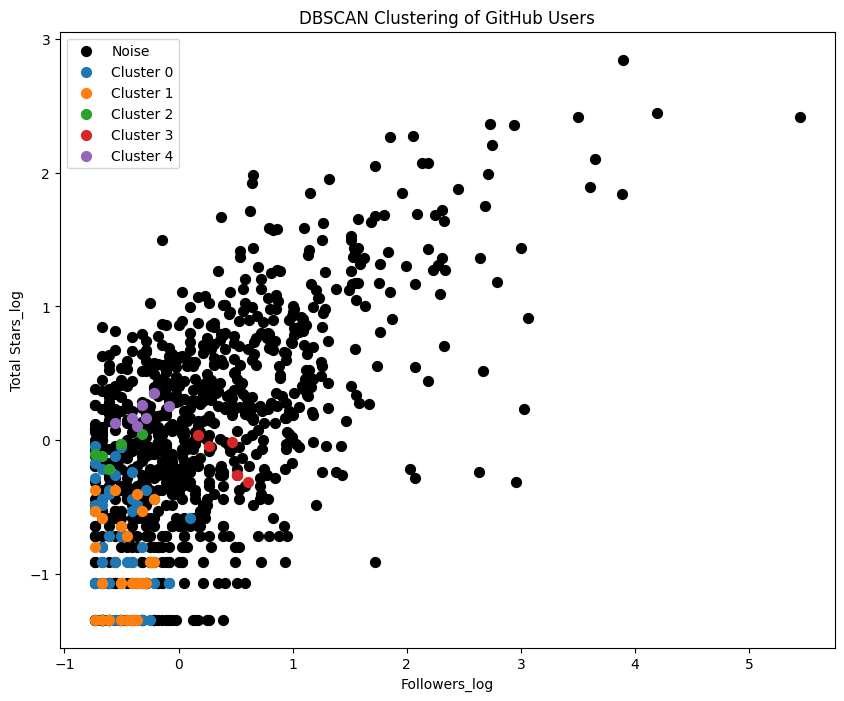


Clustered data saved to github_clusters_dbscan.csv


In [26]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Load the data
df = pd.read_csv("Cleaned_GitHub_Data-2.csv")

# --- Feature Engineering and Transformation ---
df['Followers_log'] = np.log1p(df['Followers'])
df['Total Stars_log'] = np.log1p(df['Total Stars'])
df['Total Commits_log'] = np.log1p(df['Total_Commits'])

df['Stars_per_Follower'] = df['Total Stars'] / (df['Followers'] + 1)
df['Commits_per_Repo'] = df['Total_Commits'] / (df['Public Repos'] + 1)
df['PRs_per_Issue'] = df['Total_PRs'] / (df['Total_Issues'] + 1)

df.replace([np.inf, -np.inf], 0, inplace=True)

# --- Feature Selection ---
features = ['Public Repos', 'Followers_log', 'Total Stars_log', 'Total Commits_log', 'Total_PRs', 'Total_Issues', 'Starred Repositories', 'Forked Repositories', 'Stars_per_Follower', 'Commits_per_Repo', 'PRs_per_Issue']
X = df[features].fillna(0)

# --- Scaling using RobustScaler ---
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# --- DBSCAN Clustering ---
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples as needed
clusters = dbscan.fit_predict(X_scaled)
df['Cluster'] = clusters

# --- Analyze cluster characteristics ---
print("Cluster Characteristics:\n", df.groupby('Cluster')[features].describe())

# --- Visualization (example with two features) ---
# Choose two features for visualization
feature1 = 'Followers_log'
feature2 = 'Total Stars_log'

# Scatter plot of the clusters
plt.figure(figsize=(10, 8))
for cluster_id in np.unique(clusters):
    if cluster_id == -1:
        # Noise points are often plotted in black
        plt.scatter(X_scaled[df['Cluster'] == cluster_id, features.index(feature1)],
                    X_scaled[df['Cluster'] == cluster_id, features.index(feature2)],
                    s=50, color='black', label='Noise')
    else:
        plt.scatter(X_scaled[df['Cluster'] == cluster_id, features.index(feature1)],
                    X_scaled[df['Cluster'] == cluster_id, features.index(feature2)],
                    s=50, label=f'Cluster {cluster_id}')
plt.title('DBSCAN Clustering of GitHub Users')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.legend()
plt.show()

# --- Save Results to CSV ---
df.to_csv("github_clusters_dbscan.csv", index=False)

print("\nClustered data saved to github_clusters_dbscan.csv")


In [28]:
pip install scipy

In [32]:
!pip install --upgrade scipy

Cluster Characteristics:
         Public Repos                                                         \
               count        mean        std     min     25%     50%     75%   
Cluster                                                                       
0              961.0    42.17898  49.250119     0.0    15.0    28.0    50.0   
1                1.0  1997.00000        NaN  1997.0  1997.0  1997.0  1997.0   

                Followers_log            ... Commits_per_Repo               \
            max         count      mean  ...              75%          max   
Cluster                                  ...                                 
0         595.0         961.0  3.653252  ...        29.666667  5865.550000   
1        1997.0           1.0  5.509388  ...         0.004004     0.004004   

        PRs_per_Issue                                                   \
                count         mean       std          min          25%   
Cluster                                

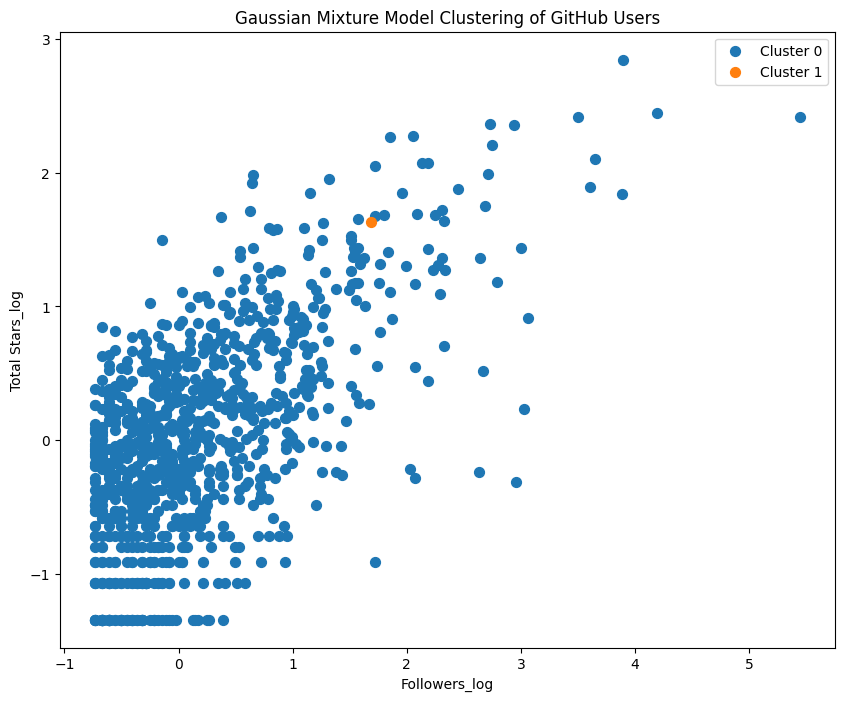


Clustered data saved to github_clusters_gmm.csv


In [33]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Load the data
df = pd.read_csv("Cleaned_GitHub_Data-2.csv")

# --- Feature Engineering and Transformation ---
# Apply log transformation to skewed features
df['Followers_log'] = np.log1p(df['Followers'])
df['Total Stars_log'] = np.log1p(df['Total Stars'])
df['Total Commits_log'] = np.log1p(df['Total_Commits'])

# Create ratio features
df['Stars_per_Follower'] = df['Total Stars'] / (df['Followers'] + 1)
df['Commits_per_Repo'] = df['Total_Commits'] / (df['Public Repos'] + 1)
df['PRs_per_Issue'] = df['Total_PRs'] / (df['Total_Issues'] + 1)

# Handle potential infinite values
df.replace([np.inf, -np.inf], 0, inplace=True)

# --- Feature Selection ---
features = ['Public Repos', 'Followers_log', 'Total Stars_log', 'Total Commits_log', 'Total_PRs', 'Total_Issues', 'Starred Repositories', 'Forked Repositories', 'Stars_per_Follower', 'Commits_per_Repo', 'PRs_per_Issue']
X = df[features].fillna(0)

# --- Scaling using RobustScaler ---
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# --- Gaussian Mixture Model ---
n_components = 2  # You want 2 clusters
gmm = GaussianMixture(n_components=n_components, random_state=0)
df['Cluster'] = gmm.fit_predict(X_scaled)

# --- Analyze cluster characteristics ---
print("Cluster Characteristics:\n", df.groupby('Cluster')[features].describe())

# --- Visualization (example with two features) ---
feature1 = 'Followers_log'
feature2 = 'Total Stars_log'

plt.figure(figsize=(10, 8))
for cluster_id in np.unique(df['Cluster']):
    plt.scatter(X_scaled[df['Cluster'] == cluster_id, features.index(feature1)],
                X_scaled[df['Cluster'] == cluster_id, features.index(feature2)],
                s=50, label=f'Cluster {cluster_id}')
plt.title('Gaussian Mixture Model Clustering of GitHub Users')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.legend()
plt.show()

# --- Save Results to CSV ---
df.to_csv("github_clusters_gmm.csv", index=False)

print("\nClustered data saved to github_clusters_gmm.csv")


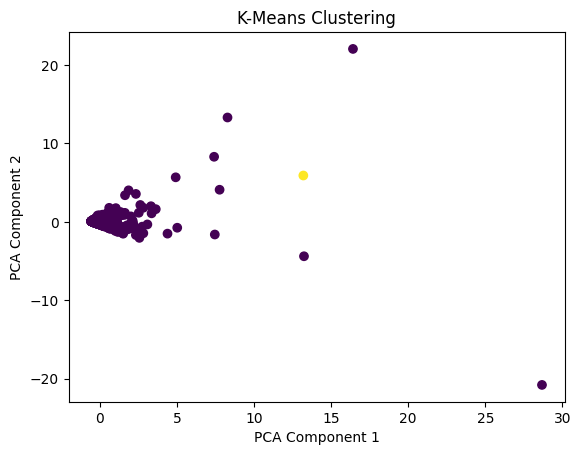

         Public Repos  Followers  Total Stars  Total_Commits  \
Cluster                                                        
0           44.038502  120.05307   358.189386    1883.990635   
1          210.000000  560.00000   808.000000  342695.000000   

         Total Pull Requests  Total Issues  
Cluster                                     
0                  107.74922     68.399584  
1                 2753.00000   1105.000000  


In [35]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('Cleaned_GitHub_Data-2.csv')

# Select relevant features for clustering
features = ['Public Repos', 'Followers', 'Total Stars', 'Total_Commits', 'Total Pull Requests', 'Total Issues']
X = df[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize the clusters (for 2D visualization, you can use PCA)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster'], cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Analyze the clusters
cluster_means = df.groupby('Cluster')[features].mean()
print(cluster_means)

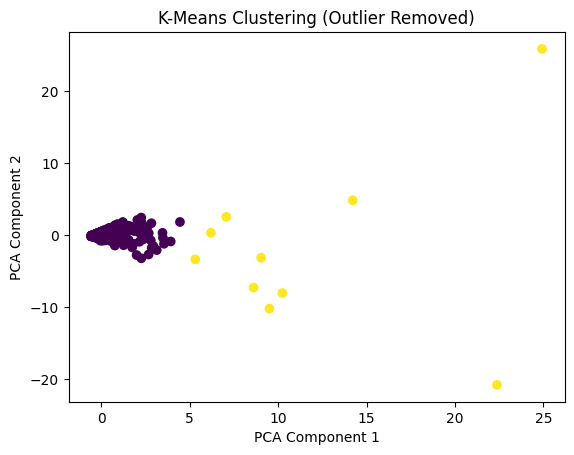

         Public Repos    Followers  Total Stars  Total_Commits  \
Cluster                                                          
0           41.044164    74.454259   258.432177    1281.988433   
1          328.800000  4456.500000  9845.100000   59134.400000   

         Total Pull Requests  Total Issues  
Cluster                                     
0                  61.990536     55.677182  
1                4459.400000   1278.300000  


In [36]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv('Cleaned_GitHub_Data-2.csv')

# Select relevant features for clustering
features = ['Public Repos', 'Followers', 'Total Stars', 'Total_Commits', 'Total Pull Requests', 'Total Issues']
X = df[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means clustering (initial run to identify outliers)
kmeans = KMeans(n_clusters=2, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Identify the outlier (the single candidate in Cluster 1)
outlier_cluster = df['Cluster'].value_counts().idxmin()
outlier_index = df[df['Cluster'] == outlier_cluster].index

# Remove the outlier
df_filtered = df.drop(outlier_index)

# Re-run K-Means on the filtered data
X_filtered = df_filtered[features]
X_filtered_scaled = scaler.fit_transform(X_filtered)

kmeans_filtered = KMeans(n_clusters=2, random_state=42)
df_filtered['Cluster'] = kmeans_filtered.fit_predict(X_filtered_scaled)

# Visualize the clusters (using PCA for 2D visualization)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_filtered_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_filtered['Cluster'], cmap='viridis')
plt.title('K-Means Clustering (Outlier Removed)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Analyze the clusters
cluster_means_filtered = df_filtered.groupby('Cluster')[features].mean()
print(cluster_means_filtered)

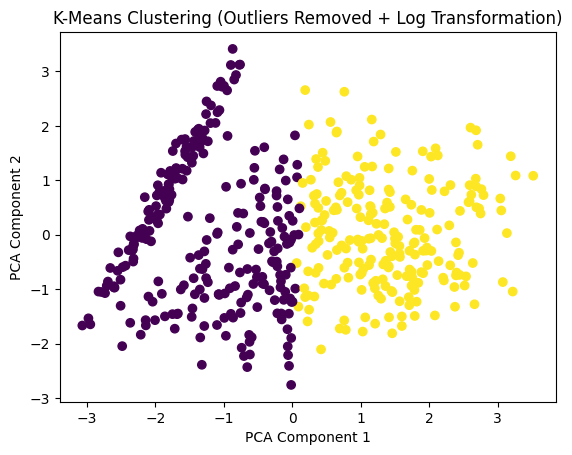

         Public Repos  Followers  Total Stars  Total_Commits  \
Cluster                                                        
0           20.104247  23.254826    23.837838      80.845560   
1           33.256637  31.075221    35.287611     364.986726   

         Total Pull Requests  Total Issues  
Cluster                                     
0                   1.227799      0.629344  
1                  11.707965      6.641593  


In [37]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load the dataset
df = pd.read_csv('Cleaned_GitHub_Data-2.csv')

# Select relevant features for clustering
features = ['Public Repos', 'Followers', 'Total Stars', 'Total_Commits', 'Total Pull Requests', 'Total Issues']
X = df[features]

# Apply log transformation to reduce the impact of extreme values
X_log = X.applymap(lambda x: np.log(x + 1))

# Standardize the log-transformed features
scaler = StandardScaler()
X_log_scaled = scaler.fit_transform(X_log)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_log_scaled)

# Identify and remove outliers using the Interquartile Range (IQR)
def remove_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

# Remove outliers for each feature
for feature in features:
    df = remove_outliers(df, feature)

# Re-run K-Means on the filtered data
X_filtered = df[features]
X_filtered_log = X_filtered.applymap(lambda x: np.log(x + 1))
X_filtered_scaled = scaler.fit_transform(X_filtered_log)

kmeans_filtered = KMeans(n_clusters=2, random_state=42)
df['Cluster'] = kmeans_filtered.fit_predict(X_filtered_scaled)

# Visualize the clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_filtered_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster'], cmap='viridis')
plt.title('K-Means Clustering (Outliers Removed + Log Transformation)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Analyze the clusters
cluster_means_filtered = df.groupby('Cluster')[features].mean()
print(cluster_means_filtered)

<ipython-input-2-c53ea798a974>:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_log = X.applymap(lambda x: np.log(x + 1))  # Add 1 to avoid log(0)
<ipython-input-2-c53ea798a974>:41: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_filtered_log = X_filtered.applymap(lambda x: np.log(x + 1))


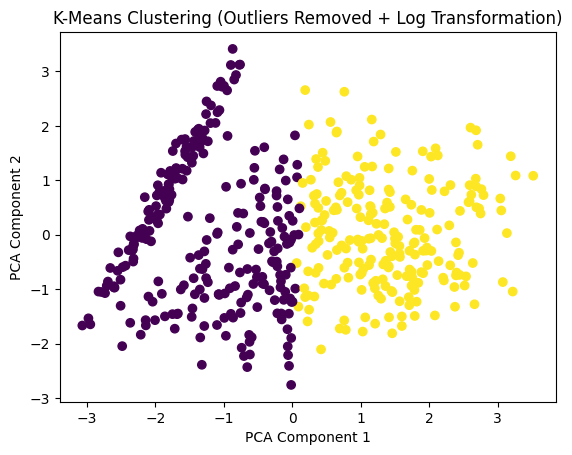

         Public Repos  Followers  Total Stars  Total_Commits  \
Cluster                                                        
0           20.104247  23.254826    23.837838      80.845560   
1           33.256637  31.075221    35.287611     364.986726   

         Total Pull Requests  Total Issues  
Cluster                                     
0                   1.227799      0.629344  
1                  11.707965      6.641593  
Clustered data saved to 'Clustered_GitHub_Data.csv'


In [2]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load the dataset
df = pd.read_csv('Cleaned_GitHub_Data-2.csv')

# Select relevant features for clustering
features = ['Public Repos', 'Followers', 'Total Stars', 'Total_Commits', 'Total Pull Requests', 'Total Issues']
X = df[features]

# Apply log transformation to reduce the impact of extreme values
X_log = X.applymap(lambda x: np.log(x + 1))  # Add 1 to avoid log(0)

# Standardize the log-transformed features
scaler = StandardScaler()
X_log_scaled = scaler.fit_transform(X_log)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_log_scaled)

# Identify and remove outliers using the Interquartile Range (IQR)
def remove_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

# Remove outliers for each feature
for feature in features:
    df = remove_outliers(df, feature)

# Re-run K-Means on the filtered data
X_filtered = df[features]
X_filtered_log = X_filtered.applymap(lambda x: np.log(x + 1))
X_filtered_scaled = scaler.fit_transform(X_filtered_log)

kmeans_filtered = KMeans(n_clusters=2, random_state=42)
df['Cluster'] = kmeans_filtered.fit_predict(X_filtered_scaled)

# Visualize the clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_filtered_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster'], cmap='viridis')
plt.title('K-Means Clustering (Outliers Removed + Log Transformation)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Analyze the clusters
cluster_means_filtered = df.groupby('Cluster')[features].mean()
print(cluster_means_filtered)

# Save the clustered data to a CSV file
df.to_csv('Clustered_GitHub_Data.csv', index=False)
print("Clustered data saved to 'Clustered_GitHub_Data.csv'")

Random Forest

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# Load the clustered data
df = pd.read_csv('Clustered_GitHub_Data.csv')

# Define features (X) and target (y)
features = ['Public Repos', 'Followers', 'Total Stars', 'Total_Commits', 'Total Pull Requests', 'Total Issues']
X = df[features]
y = df['Cluster']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Save the model (optional)
joblib.dump(rf_classifier, 'random_forest_model.pkl')
print("Model saved to 'random_forest_model.pkl'")

Accuracy: 0.94

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94        52
           1       0.95      0.91      0.93        45

    accuracy                           0.94        97
   macro avg       0.94      0.94      0.94        97
weighted avg       0.94      0.94      0.94        97


Confusion Matrix:
[[50  2]
 [ 4 41]]
Model saved to 'random_forest_model.pkl'


Neural Network

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the clustered data
df = pd.read_csv('Clustered_GitHub_Data.csv')

# Define features (X) and target (y)
features = ['Public Repos', 'Followers', 'Total Stars', 'Total_Commits', 'Total Pull Requests', 'Total Issues']
X = df[features]
y = df['Cluster']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the Neural Network
model = Sequential()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))  # Input layer
model.add(Dense(32, activation='relu'))  # Hidden layer
model.add(Dense(1, activation='sigmoid'))  # Output layer (binary classification)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model on the test set
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Save the model (optional)
model.save('neural_network_model.h5')
print("Model saved to 'neural_network_model.h5'")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.6005 - loss: 0.6586 - val_accuracy: 0.8333 - val_loss: 0.5742
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8587 - loss: 0.5509 - val_accuracy: 0.8333 - val_loss: 0.5064
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9121 - loss: 0.4750 - val_accuracy: 0.8462 - val_loss: 0.4484
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9120 - loss: 0.4294 - val_accuracy: 0.8846 - val_loss: 0.4005
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9050 - loss: 0.3600 - val_accuracy: 0.8846 - val_loss: 0.3591
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9124 - loss: 0.3103 - val_accuracy: 0.8846 - val_loss: 0.3282
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9186 - loss: 0.2898 - val_accuracy: 0.8846 - val_loss: 0.3024
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9152 - loss: 0.2426 - val_accuracy: 0.9103 - v

Accuracy: 0.89

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.90        52
           1       0.90      0.84      0.87        45

    accuracy                           0.89        97
   macro avg       0.89      0.88      0.89        97
weighted avg       0.89      0.89      0.89        97


Confusion Matrix:
[[48  4]
 [ 7 38]]
Model saved to 'neural_network_model.h5'


SVM

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# Load the clustered data
df = pd.read_csv('Clustered_GitHub_Data.csv')

# Define features (X) and target (y)
features = ['Public Repos', 'Followers', 'Total Stars', 'Total_Commits', 'Total Pull Requests', 'Total Issues']
X = df[features]
y = df['Cluster']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the SVM Classifier
svm_classifier = SVC(kernel='rbf', random_state=42)  # Use 'linear' for linear SVM

# Train the model
svm_classifier.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Save the model (optional)
joblib.dump(svm_classifier, 'svm_model.pkl')
print("Model saved to 'svm_model.pkl'")

Accuracy: 0.91

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92        52
           1       0.93      0.87      0.90        45

    accuracy                           0.91        97
   macro avg       0.91      0.90      0.91        97
weighted avg       0.91      0.91      0.91        97


Confusion Matrix:
[[49  3]
 [ 6 39]]
Model saved to 'svm_model.pkl'
